In [1]:
!wget "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
!wget "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

--2024-05-18 17:22:15--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  79.5MB/s    in 3.3s    

2024-05-18 17:22:19 (75.5 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

--2024-05-18 17:22:19--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.99MB/s    in 0.2s    

2024-05-18 17:22:19 (3.99 MB/s)

In [2]:
!unzip ml-25m.zip
!unzip ml-latest-small.zip
#!pip install livelossplot

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
!pip install pandas

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#from livelossplot import PlotLosses

import collections

import gc
from tqdm import tqdm

In [5]:
class MovieIndexing:
    def __init__(self, ratings_dataset):

        self.ratings_dataset = ratings_dataset
        self.movies_dict = {}
        self.users_dict = {}

        self.users_old_ids = []
        self.movies_old_ids = []

        self.users_train_lengths = []
        self.users_test_lengths = []
        self.movies_train_lengths = []
        self.movies_test_lengths = []

        self.maximum_user_count = 0
        self.maximum_movie_count = 0

        self.user_ratings, self.movie_ratings = self.__index_ratings()

    def __index_ratings(self):

        self.maximum_user_count = self.ratings_dataset['userId'].value_counts().max()
        self.maximum_movie_count = self.ratings_dataset['movieId'].value_counts().max()

        user_ratings = []
        movie_ratings = []

        user_counter = 0
        movie_counter = 0

        for row in tqdm(self.ratings_dataset.itertuples(), total = len(self.ratings_dataset)):
            user_id = row[1]
            movie_id = row[2]
            rating = row[3]
            timestamp = row[4]

            # User indexing
            if user_id not in self.users_dict:
                self.users_dict[user_id] = user_counter
                self.users_old_ids.append(user_id)
                user_counter += 1

            # Movie indexing
            if movie_id not in self.movies_dict:
                self.movies_dict[movie_id] = movie_counter
                self.movies_old_ids.append(movie_id)
                movie_counter += 1

            user_idx = self.users_dict[user_id]
            movie_idx = self.movies_dict[movie_id]

            # Add rating to user ratings
            while len(user_ratings) <= user_idx:
                user_ratings.append([])
            user_ratings[user_idx].append((movie_idx, rating, timestamp))

            # Add rating to movie ratings
            while len(movie_ratings) <= movie_idx:
                movie_ratings.append([])
            movie_ratings[movie_idx].append((user_idx, rating, timestamp))

        return user_ratings, movie_ratings

    def get_users_ratings(self):
      return self.user_ratings

    def get_movies_ratings(self):
      return self.movie_ratings

    def get_movie_ratings(self, movie_id):
      return self.movie_ratings[movie_id]

    def get_user_ratings(self, user_id):
      return self.user_ratings[user_id]

    def get_movie_title(self, movie_id):
      title = self.movies_dict.get(key = movie_id, default = None)
      return title

    def get_num_users(self):
      return len(self.user_ratings)

    def get_num_movies(self):
      return len(self.movie_ratings)

    def get_old_user_id(self, new_id):
      return self.users_old_ids[new_id]

    def get_old_movie_id(self, new_id):
      return self.movies_old_ids[new_id]

    def split_dataset(self, split_users = True, train_proportion = 0.9):

      if(train_proportion < 0 or train_proportion > 1):
        raise ValueError("'train_proportion' cannot be negative or more than 1.")

      test_set = []
      train_set = []
      ratings = []

      if(split_users):
        ratings = self.user_ratings
      else:
        ratings = self.movie_ratings

      for rating_list in tqdm(ratings, total = len(ratings)):

        sorted_ratings = sorted(rating_list, key = lambda x: x[-1])
        rating_list = [rating_tuple[:-1] for rating_tuple in sorted_ratings]
        total_ratings = len(rating_list)
        num_train_ratings = int(train_proportion * total_ratings)

        if(split_users == False and len(rating_list) < 10):
          train_set.append(rating_list)
          test_set.append([])
        else:
          train_set.append(rating_list[0:num_train_ratings])
          test_set.append(rating_list[num_train_ratings:])

      if(split_users):
        del self.user_ratings
      else:
        del self.movie_ratings

      return train_set, test_set


In [32]:
movies = MovieIndexing(ratings_dataset)
# movies = MovieIndexing(ratings_dataset_small)

100%|██████████| 25000095/25000095 [01:55<00:00, 215956.08it/s]


In [33]:
users_train_set, users_test_set = movies.split_dataset()
movies_train_set, movies_test_set = movies.split_dataset(split_users = False)
# users_train_set, users_test_set = movies.split_dataset(train_proportion = 1.0)
# movies_train_set, movies_test_set = movies.split_dataset(split_users = False, train_proportion = 1.0)

100%|██████████| 59047/59047 [01:14<00:00, 797.64it/s]  


In [ ]:
print(f"Size of users training set: {len(users_train_set)}    Size of users test set: {len(users_test_set)}")
print(f"Size of movies training set: {len(movies_train_set)}    Size of movies test set: {len(movies_test_set)}")

Size of users training set: 162541    Size of users test set: 162541
Size of movies training set: 59047    Size of movies test set: 59047


In [ ]:
seed = 42
rnd  = np.random.RandomState(seed)

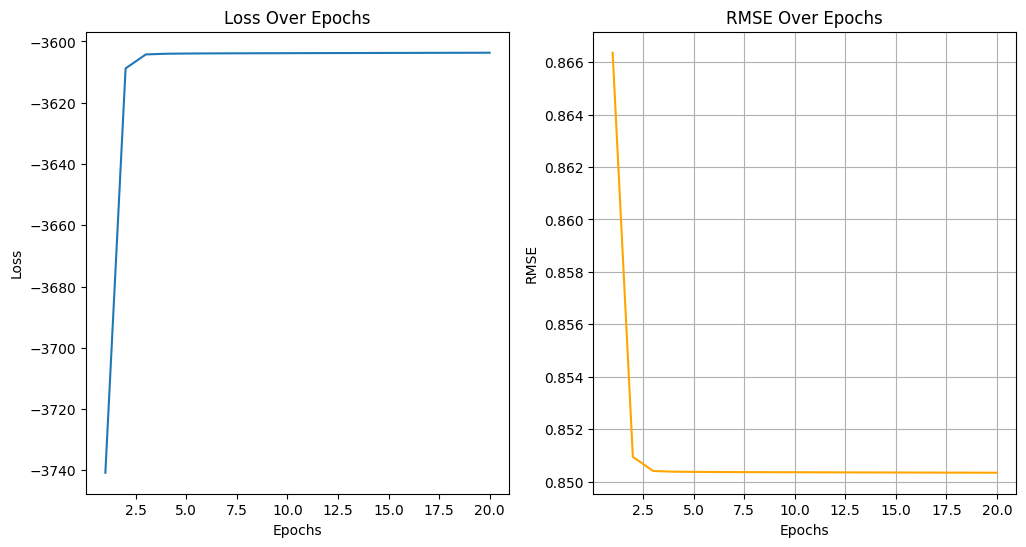

In [ ]:
plot(rmses, losses)

In [6]:
seed = 42
rnd = np.random.RandomState(seed)

In [ ]:
gc.disable()
num_users = len(users_train_set)
num_movies = len(movies_train_set)

print(f"Num users: {num_users}  Num movies: {num_movies}")

gamma = 0.0000002
spread = 1
tau = 1.5

K = 5

user_biases = np.zeros(num_users)
item_biases = np.zeros(num_movies)

u_m = np.random.normal(loc = 0, scale = (1 / np.sqrt(K)), size = (num_users, K))
v_m = np.random.normal(loc = 0, scale = (1 / np.sqrt(K)), size = (num_movies, K))

I = np.eye(K)

train_losses = []
test_losses = []

train_rmses = []
test_rmses = []

train_rmse = 0
test_rmse = 0

for i in tqdm(range(30)):
    loss = 0.0
    errors = 0.0

    # Update user biases
    for m in range(num_users):
        ratings = np.array(users_train_set[m])
        item_ids = ratings[:, 0].astype(int)
        item_ratings = ratings[:, 1]
        biases = spread * (item_ratings - item_biases[item_ids])
        user_biases[m] = np.sum(biases) / (spread * len(biases) + gamma)

    # Update user latent vectors
    for m in range(num_users):
        ratings = np.array(users_train_set[m])
        item_ids = ratings[:, 0].astype(int)
        item_ratings = ratings[:, 1]
        row_sum1 = np.dot(v_m[item_ids].T, v_m[item_ids])
        row_sum2 = np.dot(v_m[item_ids].T, (item_ratings - user_biases[m] - item_biases[item_ids]))
        product = np.linalg.solve(spread * row_sum1 + tau * I, spread * row_sum2)
        u_m[m] = product

    # Update item biases
    for n in range(num_movies):
        ratings = np.array(movies_train_set[n])
        user_ids = ratings[:, 0].astype(int)
        user_ratings = ratings[:, 1]
        biases = spread * (user_ratings - user_biases[user_ids])
        item_biases[n] = np.sum(biases) / (spread * len(biases) + gamma)

    # Update item latent vectors
    for n in range(num_movies):
        ratings = np.array(movies_train_set[n])
        user_ids = ratings[:, 0].astype(int)
        user_ratings = ratings[:, 1]
        row_sum1 = np.dot(u_m[user_ids].T, u_m[user_ids])
        row_sum2 = np.dot(u_m[user_ids].T, (user_ratings - user_biases[user_ids] - item_biases[n]))
        product = np.linalg.solve(spread * row_sum1 + tau * I, spread * row_sum2)
        v_m[n] = product

    # Compute loss and RMSE
    total = 0
    errors = 0
    train_loss = 0
    for m in range(num_users):
        user_ratings = np.array(users_train_set[m])
        item_ids = user_ratings[:, 0].astype(int)
        ratings = user_ratings[:, 1]
        predicted_ratings = np.dot(u_m[m], v_m[item_ids].T)
        l1 = 0.5 * spread * np.sum((ratings - predicted_ratings - user_biases[m] - item_biases[item_ids]) ** 2)
        l2 = np.dot(u_m[m], u_m[m])
        l3 = np.sum(np.dot(v_m[item_ids], v_m[item_ids].T))
        l4 = user_biases[m] ** 2
        l5 = np.sum(item_biases[item_ids] ** 2)
        train_loss += l1 + tau * 0.5 * (l2 + l3) + gamma * 0.5 * (l4 + l5)
        errors += np.sum((ratings - predicted_ratings - user_biases[m] - item_biases[item_ids]) ** 2)
        total += len(item_ids)

    train_rmse = np.sqrt(errors / total)
    train_rmses.append(train_rmse)
    train_losses.append(train_loss)

    # Compute test RMSE

    total = 0
    errors = 0
    test_loss = 0
    for n in range(num_users):
        user_ratings = np.array(users_test_set[n])
        item_ids = user_ratings[:, 0].astype(int)
        ratings = user_ratings[:, 1]
        predicted_ratings = np.dot(u_m[n], v_m[item_ids].T)
        l1 = 0.5 * spread * np.sum((ratings - predicted_ratings - user_biases[n] - item_biases[item_ids]) ** 2)
        l2 = np.dot(u_m[n], u_m[n])
        l3 = np.sum(np.dot(v_m[item_ids], v_m[item_ids].T))
        l4 = user_biases[n] ** 2
        l5 = np.sum(item_biases[item_ids] ** 2)
        test_loss += l1 + tau * 0.5 * (l2 + l3) + gamma * 0.5 * (l4 + l5)
        errors += np.sum((ratings - predicted_ratings - user_biases[n] - item_biases[item_ids]) ** 2)
        total += len(item_ids)

    test_rmse = np.sqrt(errors / total)
    test_rmses.append(test_rmse)
    test_losses.append(test_loss)
    print(f"Train RMSE: {train_rmse}    Test RMSE: {test_rmse} \t Train loss: {train_loss} \t Test loss: {test_loss}")

    # errors = 0
    # total = 0
    # for n in range(num_movies):
    #     user_ratings = np.array(movies_test_set[n])
    #     if(len(user_ratings) == 0):
    #         continue
    #     item_ids = user_ratings[:, 0].astype(int)
    #     ratings = user_ratings[:, 1]
    #     predicted_ratings = np.dot(v_m[n], u_m[item_ids].T)
    #     errors += np.sum((ratings - predicted_ratings - user_biases[item_ids] - item_biases[n]) ** 2)
    #     total += len(item_ids)

    # m_test_rmse = np.sqrt(errors / total)
    # #m_test_rmses.append(test_rmse)
    # print(f"Train RMSE: {train_rmse}    Test RMSE: {test_rmse} \t m_test_rmse: {m_test_rmse}")
    # #m_test_losses.append(loss)
gc.enable()

Num users: 162541  Num movies: 59047


  3%|█▎                                       | 1/30 [02:55<1:24:36, 175.05s/it]

Train RMSE: 0.8467701394437652    Test RMSE: 0.8873798185069015 	 Train loss: 178434560.57637122 	 Test loss: 5800586.02892717


In [ ]:
np.save("25M/user_vectors.npy", u_m)
np.save("25M/movie_vectors.npy", v_m)
np.save("25M/user_biases.npy", user_biases)
np.save("25M/item_biases.npy", item_biases)
np.save("25M/dimension.npy", K)
np.save("25M/gamma.npy", gamma)
np.save("25M/spread.npy", spread)
np.save("25M/tau.npy", tau)

np.save("25M/train_rmses.npy", train_rmses)
np.save("25M/train_losses.npy", train_losses)
np.save("25M/test_rmses.npy", test_rmses)
np.save("25M/test_losses.npy", test_losses)

In [ ]:
users_latent_vectors = u_m
movies_latent_vectors = v_m

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!unzip "/content/gdrive/MyDrive/final.zip"

Archive:  /content/gdrive/MyDrive/final.zip
  inflating: dimension2_l.npy        
  inflating: dimension28.npy         
  inflating: dimension_k4.npy        
  inflating: dimension_k28.npy       
  inflating: dimension_k281.npy      
  inflating: gamma2_l.npy            
  inflating: gamma28.npy             
  inflating: gamma_k4.npy            
  inflating: gamma_k28.npy           
  inflating: gamma_k281.npy          
  inflating: item_biases2_l.npy      
  inflating: item_biases28.0npy.npy  
  inflating: item_biases_k4.npy      
  inflating: item_biases_k28.npy     
  inflating: item_biases_k281.npy    
  inflating: movie_vectors2_l.npy    
  inflating: movie_vectors28.npy     
  inflating: movie_vectors_k4.npy    
  inflating: movie_vectors_k28.npy   
  inflating: movie_vectors_k281.npy  
  inflating: spread2_l.npy           
  inflating: spread28.npy            
  inflating: spread_k4.npy           
  inflating: spread_k28.npy          
  inflating: spread_k281.npy         
  infl

In [26]:
users_latent_vectors = np.load("user_vectors2_l.npy")
movies_latent_vectors = np.load("movie_vectors2_l.npy")
item_biases = np.load("item_biases2_l.npy")
user_biases = np.load("user_biases2_l.npy")
train_rmses = np.load("train_rmses2_l.npy")
train_losses = np.load("train_losses2_l.npy")
test_rmses = np.load("test_rmses2_l.npy")
test_losses = np.load("test_losses2_l.npy")
K = np.load("dimension2_l.npy")
gamma = np.load("gamma2_l.npy")
spread = np.load("spread2_l.npy")
tau = np.load("tau2_l.npy")

In [ ]:
list(test_losses)[-1]

102669.30356115353

In [18]:
def plot(rmses_train, rmses_test, losses_train, losses_test, title, K):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses_train, label = "Train")
    plt.plot(epochs, losses_test, color = 'orange', label = "Test")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over 30 Epochs for K = '+str(K))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rmses_train, label = "Train")
    plt.plot(epochs, rmses_test, color = 'orange', label = 'Test')

    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE Over 30 Epochs for K = '+str(K))

    plt.grid(True)
    plt.legend()
    plt.savefig(title+".pdf")

    plt.show()

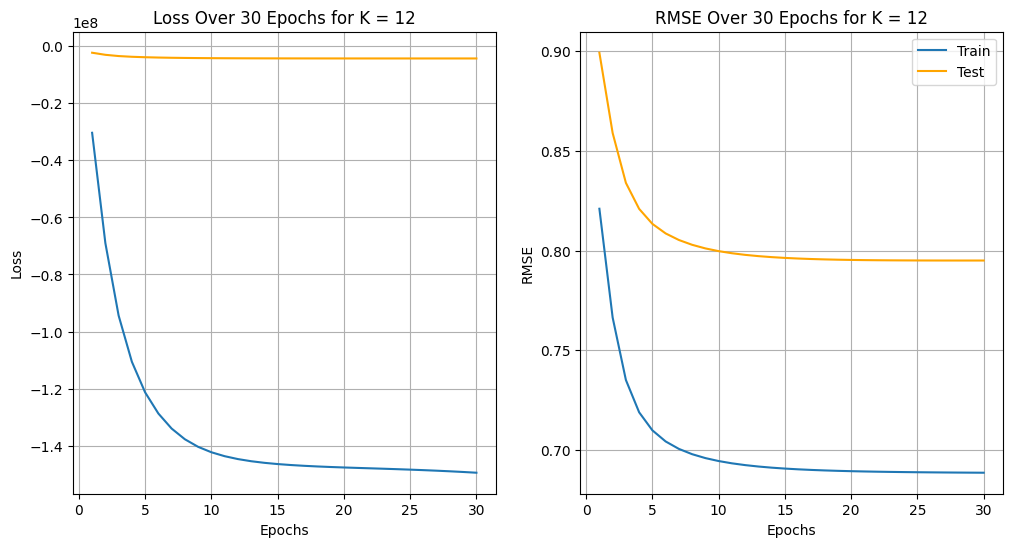

In [27]:
plot(train_rmses, test_rmses, train_losses, test_losses, "loss and rmse for K = "+str(K), K)

In [25]:
print(f"Train loss: {train_losses[-1]}")
print(f"Test loss: {test_losses[-1]}")
print(f"Train rmse: {train_rmses[-1]}")
print(f"Test rmse: {test_rmses[-1]}")
print(f"K: {K}")
print(f"Gamma: {gamma}")
print(f"Spread: {spread}")
print(f"Tau: {tau}")

Train loss: -182959685.82865566
Test loss: -4627020.646469364
Train rmse: 0.6141351389755879
Test rmse: 0.8011734188631335
K: 28
Gamma: 0.2
Spread: 1.0
Tau: 0.2


In [28]:
seed = 42
rnd  = np.random.RandomState(seed)

### Train new User

In [89]:
#K = 10
u_bias = 0
m_bias = 0

rating = 5

gamma = 0.8
spread = 0.002
tau = 1

I = np.eye(K, K)
new_u = np.random.normal(loc = 0, scale = (1 / np.sqrt(K)), size = (1, K))
new_m = np.random.normal(loc = 0, scale = (1 / np.sqrt(K)), size = (1, K))

for i in range(5):
  u_bias = spread * (rating - u_bias) / (spread + gamma)

  sum_1 = np.outer(new_m, new_m)
  sum_2 = new_m * (rating - u_bias - m_bias)
  product = np.linalg.inv(spread * sum_1 + tau * I).dot((spread * sum_2).squeeze())
  new_u = product

  m_bias = spread * (rating - m_bias) / (spread + gamma)

  sum_1 = np.outer(new_u, new_u)
  sum_2 = new_u * (rating - u_bias - m_bias)
  product = np.linalg.inv(spread * sum_1 + tau * I).dot((spread * sum_2).squeeze())
  new_m = product

  error = (rating - np.dot(new_u, new_m) - u_bias - m_bias) ** 2
  print(f"Epoch: {i} \t RMSE: {error: .4f} \t User bias: {u_bias: .4f} \t Movie bias: {m_bias: .4f}")

Epoch: 0 	 RMSE:  24.7512 	 User bias:  0.0125 	 Movie bias:  0.0125
Epoch: 1 	 RMSE:  24.7519 	 User bias:  0.0124 	 Movie bias:  0.0124
Epoch: 2 	 RMSE:  24.7519 	 User bias:  0.0124 	 Movie bias:  0.0124
Epoch: 3 	 RMSE:  24.7519 	 User bias:  0.0124 	 Movie bias:  0.0124
Epoch: 4 	 RMSE:  24.7519 	 User bias:  0.0124 	 Movie bias:  0.0124


In [34]:
def rank_movies():
    pairs = []
    scores = []
    scores_rank = []
    for i in range(len(movies_latent_vectors)):
        score = np.dot(new_u, movies_latent_vectors[i]) + 0.05 * item_biases[i]
        scores.append((score, i))
    sorted_scores = sorted(scores, key = lambda x: x[0])

    top_scores = []
    for score, movie_index in sorted_scores:
        if(len(movies_train_set[movie_index]) > 100):
          movie_id = movies.get_old_movie_id(movie_index)
          pairs.append((movie_index, movie_id))
          top_scores.append(movie_id)
          scores_rank.append(score)
    print(len(top_scores))
    #filtered_titles = movies_dataset[movies_dataset['movieId'].isin(top_scores)]['title']
    return scores_rank, top_scores, scores, pairs


In [ ]:
print(new_u)
print(new_m)

[ 2.00035506 -0.08283249  1.36801744  0.72791832  0.33492904 -0.87883501
  0.99889196 -1.21403768  1.38070329 -0.79975166  0.44378642  0.43204764
 -0.36667291]
[ 0.21723506 -0.00899546  0.1485643   0.07905066  0.03637271 -0.09543994
  0.10847792 -0.13184237  0.14994196 -0.08685163  0.04819443  0.04691962
 -0.03982004]


In [90]:
rank, top_scorers, scores, pairs = rank_movies()

9899


In [91]:
#print(top_scorers[:10])
titles = [movies_dataset.loc[movies_dataset['movieId'] == scorer, 'title'].values[0] for scorer in top_scorers]

In [92]:
print(titles[-10:])
print(top_scorers[-10:])
print(rank[-10:])
#top_ten_recommendations = pd.DataFrame(titles[-10], columns = ['Title'])

['12 Angry Men (1957)', 'Cosmos', 'The Blue Planet (2001)', 'Century of the Self, The (2002)', 'Band of Brothers (2001)', 'Life (2009)', 'Blue Planet II (2017)', 'Shawshank Redemption, The (1994)', 'Planet Earth II (2016)', 'Planet Earth (2006)']
[1203, 171495, 142115, 105250, 170705, 159819, 179135, 318, 171011, 159817]
[0.03768442599415367, 0.0377252656158001, 0.04033724176598286, 0.04088925836342577, 0.041584549634718526, 0.042465158337983415, 0.04281422476320074, 0.04286344792810581, 0.04872656281749027, 0.04932526595808512]


### Top 10 recommendation for new user

In [101]:
top_list = titles[-10:]
top_ten_recommendations = pd.DataFrame({'Title': top_list})
top_ten_recommendations.iloc[::-1]

,Title
9,Planet Earth (2006)
8,Planet Earth II (2016)
7,"Shawshank Redemption, The (1994)"
6,Blue Planet II (2017)
5,Life (2009)
4,Band of Brothers (2001)
3,"Century of the Self, The (2002)"
2,The Blue Planet (2001)
1,Cosmos
0,12 Angry Men (1957)


In [ ]:
print(pairs[:10])

[(79, 318), (76, 260), (82, 356), (260, 593), (0, 296), (159, 2571), (86, 480)]


In [ ]:
a = []
a.append((-2, 3))
a.append((100, 2))
a.append((-7, 1))
a.append((4, 20))
b = sorted(a, key = lambda x: x[0])
print(b[2:])

[(4, 20), (100, 2)]


print(movies.movies_dict.get(480))

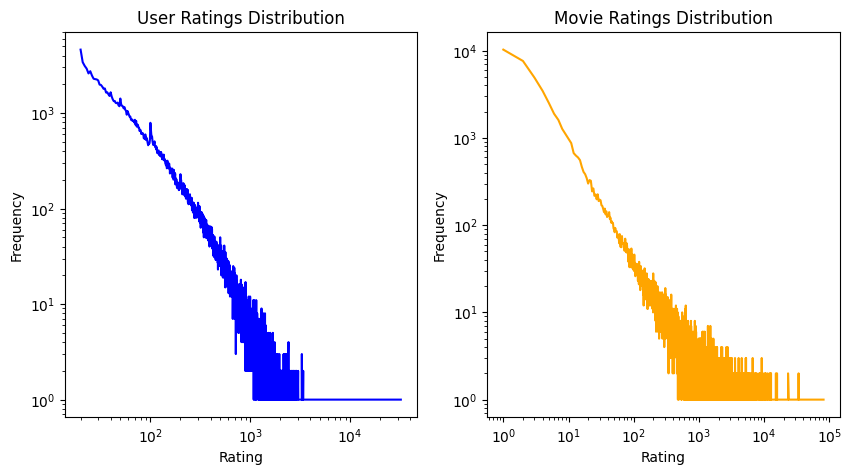

In [ ]:
user_ratings_freq = ratings_dataset['userId'].value_counts().sort_index()
movie_ratings_freq = ratings_dataset['movieId'].value_counts().sort_index()

unique_user_ratings, user_freqs = np.unique(np.array(user_ratings_freq), return_counts = True)
unique_movie_ratings, movie_freqs = np.unique(np.array(movie_ratings_freq), return_counts = True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.loglog(unique_user_ratings, user_freqs, color = 'blue')
plt.title('User Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.loglog(unique_movie_ratings, movie_freqs, color = 'orange')
plt.title('Movie Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('power_law_dist.pdf')

plt.show()

In [ ]:
gc.disable()
num_users = len(users_train_set)
num_movies = len(movies_train_set)

print(f"Num users: {num_users}  Num movies: {num_movies}")

gamma = 0.0000002
spread = 1.2
tau = 0.00005

K = 10

user_biases = np.zeros(num_users)
item_biases = np.zeros(num_movies)

train_losses = []
test_losses = []

train_rmses = []
test_rmses = []

train_rmse = 0
test_rmse = 0

for i in tqdm(range(30)):
    # Update user biases
    for m in range(num_users):
        ratings = np.array(users_train_set[m])
        item_ids = ratings[:, 0].astype(int)
        item_ratings = ratings[:, 1]
        biases = spread * (item_ratings - item_biases[item_ids] - user_biases[m])
        user_biases[m] = np.sum(biases) / (spread * len(biases) + gamma)


    for n in range(num_movies):
        ratings = np.array(movies_train_set[n])
        user_ids = ratings[:, 0].astype(int)
        user_ratings = ratings[:, 1]
        biases = spread * (user_ratings - user_biases[user_ids] - item_biases[n])
        item_biases[n] = np.sum(biases) / (spread * len(biases) + gamma)

    total = 0
    errors = 0
    loss = 0
    for m in range(num_users):
        ratings = np.array(users_train_set[m])
        item_ids = ratings[:, 0].astype(int)
        item_ratings = ratings[:, 1]
        errors += np.sum((item_ratings - item_biases[item_ids]) ** 2)
        loss += -0.5 * spread * np.sum((item_ratings - item_biases[item_ids] - user_biases[m]) ** 2) - 0.5 * gamma * (user_biases[m] ** 2 + np.sum(item_biases[item_ids] ** 2))
        total += len(item_ratings)
    train_rmses.append(errors / total)
    train_losses.append(loss)


Num users: 610  Num movies: 9724


100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.24it/s]


In [8]:
import seaborn as sns

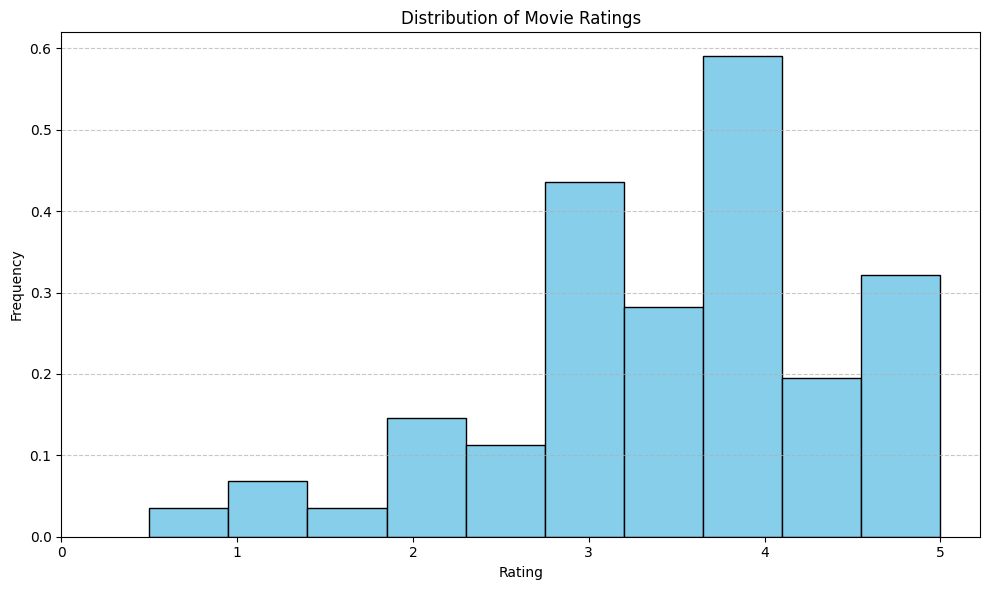

3.65
4.1


In [31]:
plt.figure(figsize=(10, 6))  # Set the size of the plot

hist, bins, _ = plt.hist(ratings_dataset['rating'], bins=10, color='skyblue', edgecolor='black', density = True)
max_bin_idx = np.argmax(hist)
max_bin = bins[max_bin_idx]

plt.title('Distribution of Movie Ratings')  # Set the title of the plot
plt.xlabel('Rating')  # Set the label for the x-axis
plt.ylabel('Frequency')  # Set the label for the y-axis
plt.xticks(range(6))  # Set ticks for x-axis (0 to 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("histogram_of_ratings.pdf")
plt.show()
print(max_bin)
print(bins[max_bin_idx + 1])


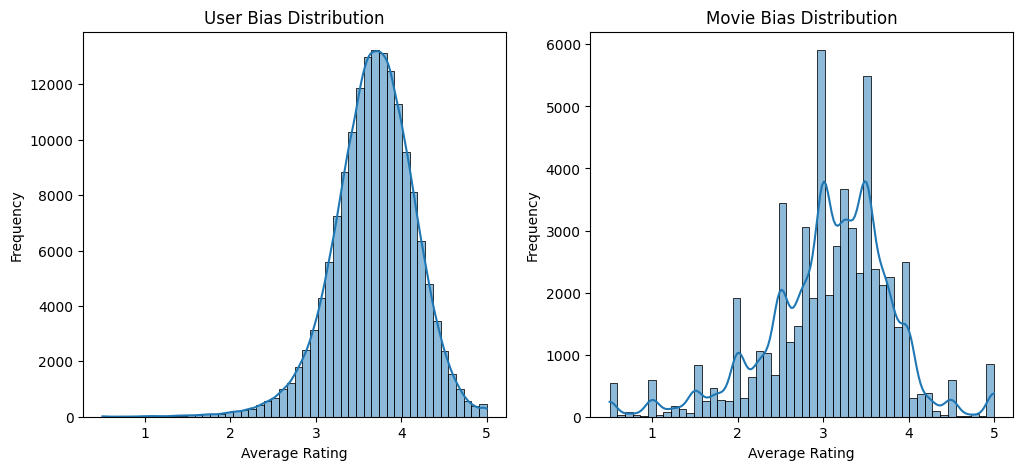

In [33]:
user_bias = ratings_dataset.groupby('userId')['rating'].mean()
item_bias = ratings_dataset.groupby('movieId')['rating'].mean()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(user_bias, bins=50, kde=True)
plt.title('User Bias Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
#plt.show()

plt.subplot(1, 2, 2)
sns.histplot(item_bias, bins=50, kde=True)
plt.title('Movie Bias Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.savefig("user_and_item_bias_distribution.pdf")
plt.show()
